In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
class ReadDataCSV(Dataset):
    def __init__(self, csv_file_path, train=True, transform=None):
        data = pd.read_csv(csv_file_path)

        raw = data.to_numpy
        num_images = data.shape[0]
        image_as_array = data.values[:,1:]
        label_as_array = data.values[:,0]
        self.images_numpy = image_as_array.reshape(num_images, 150, 150, 3)
        self.targets = label_as_array
        self.transform = transform
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.images_numpy[index], self.targets[index]
        img = img.squeeze().astype(np.uint8)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        target = torch.tensor(target)
        return img, target

In [7]:
dataset = ReadDataCSV("test_data.csv",transform=img_transform)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


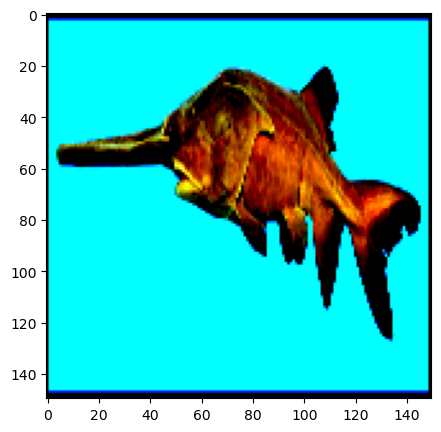

In [8]:
[imgs,labels] = (next(iter(dataloader)))
imgs = np.squeeze(imgs)
plt.figure(figsize=(5,5))
plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())

In [9]:
# # Load the Pre-Trained ResNet Model
# resnet_cnn = models.resnet18()
# for param in resnet_cnn.parameters():
#     param.requires_grad = False
# resnet_cnn.fc = torch.nn.Linear(resnet_cnn.fc.in_features, 290)
# for param in resnet_cnn.fc.parameters():
#     param.requires_grad = True
# resnet_cnn.eval()

# # Move the model to the GPU if possible
# if torch.cuda.is_available():
#     resnet_cnn.to('cuda')

# for inputs, labels in dataloader:
#     if torch.cuda.is_available():
#         inputs = inputs.to('cuda')
    
#     with torch.no_grad():
#         outputs = resnet_cnn(inputs)
#     probabilities = torch.nn.functional.softmax(outputs, dim=1)

#     _, predicted_indices = torch.max(probabilities, 1)

#     # for i in range(len(labels)):
#     #     print(f'Predicted class: {dataset.targets[predicted_indices[i]]}, Ground truth: {dataset.targets[labels[i]]}')
#     correct = 0
#     for i, label in enumerate(labels):
#         # print("Predicted class: " + str(dataset.targets[predicted_indices[i]]) + ", Ground Truth Class: " + label)
#         if dataset.targets[predicted_indices[i]] == label:
#             correct += 1
#     print("correct: " + str(correct) + ", wrong: " + str(len(labels)-correct))
#     # # Debug the probabilities tensor
#     # print("Probabilities shape:", dataset.targets.shape)
#     # print("Probabilities values:", dataset.images_numpy.shape)

#     # # Debug the predicted indices
#     # print("Predicted indices max value:", torch.max(predicted_indices))

In [11]:
train_dataset = ReadDataCSV("train_data.csv",transform=img_transform)
test_dataset = ReadDataCSV("test_data.csv",transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN Class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Step 1: Create the first convolutional layer (conv1)
        #   - Input channels: 3
        #   - Output channels: 6
        #   - Kernel size: 5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        
        # Step 2: Create max pooling layer (pool)
        #   - Kernel size: 2
        #   - Stride: 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Step 3: Create the second convolutional layer (conv2)
        #   - Input channels: 6
        #   - Output channels: 16
        #   - Kernel size: 5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        # Step 4: Create the first fully connected layer (fc1)
        #   - Input features: 16 * 5 * 5
        #   - Output features: 120
        self.fc1 = nn.Linear(16 * 34 * 34, 120)

        # Step 5: Create the second fully connected layer (fc2)
        #   - Input features: 120
        #   - Output features: 120
        self.fc2 = nn.Linear(120, 120)

        # Step 6: Create the third fully connected layer (fc3)
        #   - Input features: 120
        #   - Output features: 10 (number of classes in CIFAR-10)
        self.fc3 = nn.Linear(120, 16)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
 
        batch_size = x.size(0)
        flattened_size = x.size(1) * x.size(2) * x.size(3)
        self.fc1 = nn.Linear(flattened_size, 120)

        x = x.view(batch_size, -1)
        #x = x.view(256, -1)
        #print(x.shape)

        x = F.relu(self.fc1(x))
        #print(x.shape)
        
        x = F.relu(self.fc2(x))
        #print(x.shape)

        x = self.fc3(x)
        #print(x.shape)

        #   - Return output
        #print(Net())
        return F.log_softmax(x, dim=1)

In [17]:
#model = models.resnet18(weights=models.ResNet18_Weights)
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, 290)

net = Net()

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)


for epoch in range(25):
    ##model.train()

    running_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs,labels = inputs.to(device), labels.to(device)

        #print(labels.max())
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch [{epoch+1}/{10}], Loss: {running_loss / len(train_dataloader.dataset)}")

    ##model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("correct: " + str(correct))
    accuracy = 100 * correct / total
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

Epoch [1/10], Loss: 2.7660609148243203
correct: 33
Accuracy on test set after epoch 1: 5.95%
Epoch [2/10], Loss: 2.755467267796784
correct: 35
Accuracy on test set after epoch 2: 6.31%
Epoch [3/10], Loss: 2.742122961161409
correct: 35
Accuracy on test set after epoch 3: 6.31%
Epoch [4/10], Loss: 2.7270172956700085
correct: 35
Accuracy on test set after epoch 4: 6.31%
Epoch [5/10], Loss: 2.713860253910494
correct: 35
Accuracy on test set after epoch 5: 6.31%
Epoch [6/10], Loss: 2.6997882601750156
correct: 35
Accuracy on test set after epoch 6: 6.31%
Epoch [7/10], Loss: 2.688500829424738
correct: 35
Accuracy on test set after epoch 7: 6.31%
Epoch [8/10], Loss: 2.6737187224059227
correct: 35
Accuracy on test set after epoch 8: 6.31%
Epoch [9/10], Loss: 2.6542717090201173
correct: 35
Accuracy on test set after epoch 9: 6.31%
Epoch [10/10], Loss: 2.642343738710728
correct: 35
Accuracy on test set after epoch 10: 6.31%
Epoch [11/10], Loss: 2.628049040999882
correct: 35
Accuracy on test set a

In [19]:
CUDA=torch.cuda.is_available()

#model = models.resnet18(weights=models.ResNet18_Weights)
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, 290)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
accuracy_values=[]
epoch_number=[]
if CUDA:
    net.cuda()
for epoch in range(100):  # loop over the dataset multiple times. Here 10 means 10 epochs
    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_dataloader, 0):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs = inputs.cpu()
            labels = labels.cpu()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[epoch%d, itr%5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            if CUDA:
                images = images.cuda()
                labels = labels.cuda()
            else:
                images = images.cpu()
                labels =labels.cpu()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if CUDA:
              correct += (predicted.cpu()==labels.cpu()).sum().item()
            else:
              correct += (predicted==labels).sum().item()

        TestAccuracy = 100 * correct / total
        epoch_number += [epoch+1]
        accuracy_values += [TestAccuracy]
        print('Epoch=%d Test Accuracy=%.3f' %
                  (epoch + 1, TestAccuracy))

print('Finished Training')

Epoch=1 Test Accuracy=7.027
Epoch=2 Test Accuracy=6.667
Epoch=3 Test Accuracy=6.667
Epoch=4 Test Accuracy=6.667
Epoch=5 Test Accuracy=6.306
Epoch=6 Test Accuracy=5.946
Epoch=7 Test Accuracy=6.667
Epoch=8 Test Accuracy=5.586
Epoch=9 Test Accuracy=7.027
Epoch=10 Test Accuracy=7.928
Epoch=11 Test Accuracy=7.387
Epoch=12 Test Accuracy=6.667
Epoch=13 Test Accuracy=5.586
Epoch=14 Test Accuracy=7.568
Epoch=15 Test Accuracy=6.667
Epoch=16 Test Accuracy=6.667
Epoch=17 Test Accuracy=7.387
Epoch=18 Test Accuracy=6.306
Epoch=19 Test Accuracy=6.847
Epoch=20 Test Accuracy=5.766
Epoch=21 Test Accuracy=5.946
Epoch=22 Test Accuracy=7.207
Epoch=23 Test Accuracy=6.486
Epoch=24 Test Accuracy=7.027
Epoch=25 Test Accuracy=7.568
Epoch=26 Test Accuracy=7.928
Epoch=27 Test Accuracy=7.207
Epoch=28 Test Accuracy=7.207
Epoch=29 Test Accuracy=6.306
Epoch=30 Test Accuracy=7.748
Epoch=31 Test Accuracy=8.468
Epoch=32 Test Accuracy=7.568
Epoch=33 Test Accuracy=8.468
Epoch=34 Test Accuracy=7.027
Epoch=35 Test Accuracy=